<a href="https://colab.research.google.com/github/mcagriaksoy/C-ExercisesForInterviews/blob/main/Pollen_classification_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mehmet Cagri Aksoy . 2024
#github.com/mcagriaksoy

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip /content/drive/MyDrive/Datasets/Pollen/Pollen_Dataset.zip

In [4]:
CLASS_NUMBER = 97
channels = 3
img_height = 128
img_width = 128
epochs = 100
batch_size = 16

input_shape = (img_height,img_width,channels)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# We'll build the CNN as a sequence of layers.
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
# Libraries to handle the data
import json
from PIL import Image # PIL = Python Image Library
from skimage.transform import resize
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

In [7]:
img_augmented = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=0.1,
    width_shift_range=0.1,
    brightness_range=(0.8,1.2),
    zoom_range = [1, 1.2],
    validation_split=0.2
)

dir = '/content/Pollen_Dataset/train'

train_dataset = img_augmented.flow_from_directory(batch_size=batch_size,
                                                 directory=dir,
                                                 shuffle=False,
                                                 target_size=(img_height,img_width),
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = img_augmented.flow_from_directory(batch_size=batch_size,
                                                 directory=dir,
                                                 shuffle=False,
                                                 target_size=(img_height,img_width),
                                                 subset="validation",
                                                 class_mode='categorical')


Found 5937 images belonging to 97 classes.
Found 1471 images belonging to 97 classes.


In [8]:
train_classes = train_dataset.classes

In [9]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))

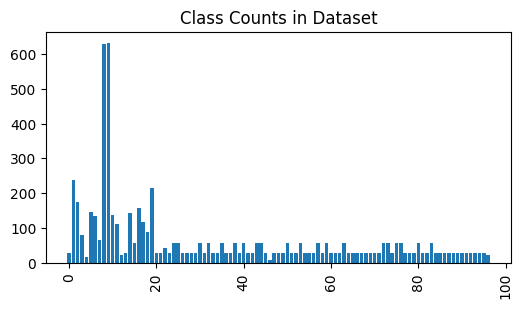

In [10]:
from collections import Counter
counter = Counter(train_dataset.classes)

plt.figure(figsize = (6,3))
plt.title('Class Counts in Dataset')
plt.bar(*zip(*counter.items()))
plt.xticks(rotation='vertical')
plt.show()

In [11]:
base_model = tf.keras.applications.EfficientNetV2B2(input_shape = input_shape, include_top = False, weights = "imagenet")
base_model.trainable = False
model = tf.keras.Sequential([base_model,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dropout(0.05),
                             tf.keras.layers.Dense(CLASS_NUMBER, activation="softmax")
                            ])
model.summary()

35839040/35839040 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Functio  (None, 4, 4, 1408)        8769374   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 97)                136673    
                                                                 
Total params: 8906047 (33.97 MB)
Trainable params: 136673 (533.88 KB)
Non-trainable params: 8769374 (33.45 MB)
____________

In [12]:
model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = 'efficientnet_best.h5'
callback = [EarlyStopping(monitor ='val_loss', patience = 2),
             ModelCheckpoint(filepath = model_path, save_best_only = True, mode='min', verbose=1)]

In [ ]:
from keras.models import load_model

#Reload model
#model = load_model('best_model (4).h5')

In [ ]:
model.fit(
    train_dataset,
    steps_per_epoch = train_dataset.samples // batch_size,
    validation_data = validation_dataset,
    validation_steps = validation_dataset.samples // batch_size,
    epochs = 50,
    class_weight = class_weights,
    callbacks = callback
    )

Epoch 1/50
255/371 [===================>..........] - ETA: 1:04 - loss: 5.5663 - accuracy: 0.0084